In [5]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(4712)

# Queueing simulation with antithetic draws

In [6]:
def exponential_rng(lam, u):
    """ Generates exponential random number.
    
    Keywords:
        lam (float): the rate parameter, the inverse expectation of the distribution.
        u (float): Uniform random number.
    
    Returns:
        exponential random number with given rate.
    """
    return -np.log(u) / lam

In [7]:
class Event:
    """ Generic event.
    
    Attributes:
        time (float): Event time.
    """
    
    def __init__(self, time):
        self.time = time
        
class Generation(Event):
    """ Generation event.
    
    Attributes:
        time (float): Event time.
    """
    def __init__(self, time):
        super().__init__(time)
        
class Arrival(Event):
    """ Arrival event.
    
    Attributes:
        time (float): Event time.
    """
    def __init__(self, time):
        super().__init__(time)
        
class Departure(Event):
    """ Departure event.
    
    Attributes:
        time (float): Event time.
    """
    def __init__(self, time):
        super().__init__(time)
        
class Termination(Event):
    """ Termination event.
    
    Attributes:
        time (float): Event time.
    """
    def __init__(self, time):
        super().__init__(time)

In [277]:
class Scenario:
    """ Road scenario
    
    Attributes:
        demand duration (float): Duration of vehicle generation.
        t0 (float): Free-flow travel time.
        lam (float): Entry rate.
        mu (float): Service rate.
    """
    
    def __init__(self, 
                 demand_duration=50.0,
                 t0=1.0,
                 lam=1.0,
                 mu=1.0,
                ):
        self.demand_duration = demand_duration
        self.t0 = t0
        self.lam = lam
        self.mu = mu

In [291]:
def simulate(scenario, u):
    """ Implements the simulation procedure.
    
    Keywords:
        scenario (Scenario): Road scenario.
        u (array): 3 x N array of uniform random numbers, N must be sufficiently large.
    
    Returns:
        times (list): Event times. 
        queues (list): Queue length over time. 
    """
    
    times = [0]
    queues = [0]
    # Time variable
    t = 0
    # Counter variables
    NA, ND = 0, 0
    # System state variable
    n = 0
    # Parameters
    demand_duration = scenario.demand_duration
    t0 = scenario.t0
    lam = scenario.lam
    mu = scenario.mu
    # Random vectors
    ug = iter(u[0, :])
    ut = iter(u[1, :])
    us = iter(u[2, :])
    # Event list
    EL = [0, np.inf, demand_duration]
    # Initialization of the simulation
    generation = Generation(0)
    # List of arrival times
    l_ta = []
    while True:
        # Create generation event
        generation.time += exponential_rng(lam, next(ug))
        tg = generation.time
        # Create arrival event
        arrival = Arrival(t0 * next(ut))
        tt = arrival.time
        ta = tg + tt
        l_ta.append(ta)
        if ta > EL[2]:
            break
    # Sort arrival times
    l_ta.sort()
    # Convert list to an iterator
    l_ta = iter(l_ta)
    # Add arrival to the event list
    EL[0] = next(l_ta)
    while True:
        if EL[0] == min(EL):
            # Reset
            t = EL[0]
            n += 1
            NA += 1
            # Collect
            times.append(t)
            queues.append(n)
            # Generate an arrival
            EL[0] = next(l_ta)
            if n == 1:
                # Generate first departure
                departure = Departure(exponential_rng(mu, next(us)))
                ts = departure.time
                td = t + ts
                EL[1] = td
        elif EL[1] == min(EL):
            # Reset
            t = EL[1]
            n -= 1
            ND += 1
            # Collect
            times.append(t)
            queues.append(n)
            if n > 0:
                # Generate a departure
                departure = Departure(exponential_rng(mu, next(us)))
                ts = departure.time
                td = t + ts
                EL[1] = td
            else:
                # Queue is empty
                td = np.inf
                EL[1] = td
        elif EL[0] > min(EL[1:]):
            if n > 0:
                # Reset
                t = EL[1]
                n -= 1
                ND += 1
                # Collect
                times.append(t)
                queues.append(n)
                while n > 0:
                    # Generate a departure
                    departure = Departure(exponential_rng(mu, next(us)))
                    ts = departure.time
                    td = t + ts
                    EL[1] = td
                    # Reset
                    t = EL[1]
                    n -= 1
                    ND += 1
                    # Collect
                    times.append(t)
                    queues.append(n)
            else:
                # Terminate
                termination = Termination(t)
                break
        
    return times, queues

In [292]:
def moving_mean_var(new_data, old_mean, old_var, t):
    """ Calculates moving sameple mean and variance at time t.
    
    Keywords:
        new_data (float): new data point arriving at time t.
        old_mean (float): previous sample mean.
        old_var (float): previous sample variance.
        t (int): time index
    
    Returns:
        new_mean (float): updated sample mean.
        new_var (float): updated sample variance.
    """

    new_mean = old_mean + (new_data - old_mean) / (t + 1)
    if t == 0:
        new_var = 0
    else:
        new_var = (1 - 1 / t) * old_var + (t + 1) * (new_mean - old_mean)**2
    return new_mean, new_var

### Independent runs

In [503]:
#Requested precision for the estimation of the average maximum queue length.
#Empirically calculated such that approximately 100 simulation runs are necessary.
precision = 0.5

max_queue_mean = 0
max_queue_var = 0
max_queue_all = []
max_queue_mean_all = []
max_queue_var_all = []
run = 0

scenario = Scenario()
np.random.seed(1234)
#Main loop
while True:
    run += 1

    #Run simulation
    u = np.random.rand(3, 1000)
    _, queues = simulate(scenario, u)
    max_queue = max(queues)

    #Collect statistics
    max_queue_mean, max_queue_var = moving_mean_var(max_queue, max_queue_mean,
                                                    max_queue_var, run)
    max_queue_all.append(max_queue)
    max_queue_mean_all.append(max_queue_mean)
    max_queue_var_all.append(max_queue_var)

    #Check if necessary precision reached
    if run >= 100 and np.sqrt(max_queue_var / run) < precision:
        break

sd_independent = np.sqrt(max_queue_var_all)

### Antithetic runs

In [504]:
max_queue_mean = 0
max_queue_var = 0
max_queue_all = []
max_queue_mean_all = []
max_queue_var_all = []
scenario = Scenario()
np.random.seed(1234)

for run in np.arange(0, sd_independent.shape[0], 2):
    #Run simulation
    u = np.random.rand(3, 1000)
    _, queues_ind = simulate(scenario, u)
    max_queue_ind = max(queues_ind)
    _, queues_ant = simulate(scenario, 1 - u)
    max_queue_ant = max(queues_ant)
    max_queue = (max_queue_ind - max_queue_ant) / 2

    #Collect statistics
    max_queue_mean, max_queue_var = moving_mean_var(max_queue, max_queue_mean,
                                                    max_queue_var, run)
    max_queue_all.append(max_queue)
    max_queue_mean_all.append(max_queue_mean)
    max_queue_var_all.append(max_queue_var)

sd_antithetic = np.sqrt(max_queue_var_all)

Plot the standard deviation of maximum queue length.

In [505]:
sd_independent = np.insert(sd_independent, 0, 0)
sd_antithetic = np.insert(sd_antithetic, 0, 0)

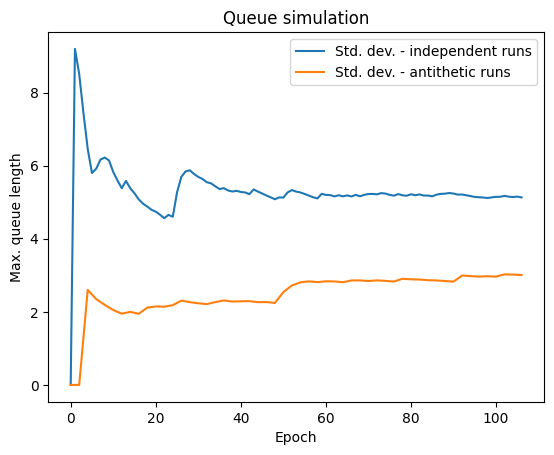

In [506]:
fig = plt.figure()
ax = plt.subplot(1,1,1)
ax.plot(sd_independent, label='Std. dev. - independent runs')
ax.plot(np.arange(0,sd_independent.shape[0],2), sd_antithetic, label='Std. dev. - antithetic runs')
ax.set(title='Queue simulation',
       xlabel='Epoch',
       ylabel='Max. queue length')
ax.legend()
#fig.savefig('figure_antithetic.pdf', dpi=300)
plt.show()

# Queueing simulation with control variates

In [ ]:
def controlled_mean(x, y, mu):
    """ Calculates the controlled mean.
    
    Keywords:
        x (array): Data.
        y (array): Control data.
        mu (float): Scalar expectation of the control data.
    
    Returns:
        avg (float): Controlled mean of the data.
        var (float): Variance of the controlled mean.
        z (array): Optimal linear combination of the data and the control data. 
    """

    ###
    #ADD YOUR CODE HERE
    ###
    
    return avg, var, z

In [ ]:
def simulate(scenario):
    """ Implements the simulation procedure.
    
    Keywords:
        scenario (Scenario): Road scenario.
    
    Returns:
        times (list): Event times. 
        queues (list): Queue length over time. 
        service_time_mean (float): Mean service time
    """
    
    ###
    #ADD YOUR CODE HERE
    ###

In [ ]:
#Requested precision for the estimation of the average maximum queue length. 
#Empirically calculated such that approximately 100 simulation runs are necessary.
precision = 0.5

###
#ADD YOUR CODE HERE
###

sd_control = np.sqrt(max_queue_var_control_all)

Information on correlation

In [ ]:
np.corrcoef(service_time_mean_all, max_queue_all)

In [ ]:
fig = plt.figure()
ax = plt.subplot(1,1,1)

ax.plot(sd_independent, label='Std. dev. - independent runs')
ax.plot(sd_control, label='Std. dev. - controlled runs')
ax.set(title='Queue simulation',
       xlabel='Epoch',
       ylabel='Max. queue length')
ax.legend()
#fig.savefig('figure_control_variates.pdf', dpi=300)
plt.show()